In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
main_dir = '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/'

!ls -ltra '{main_dir}'/.

Mounted at /content/gdrive
ls: '/content/gdrive/My Drive/UpworkNotebooks/Opera Files//./Audios': No such file or directory
total 36
lrw------- 1 root root    0 May  1  2021 Audios -> /content/gdrive/.shortcut-targets-by-id/1DOvML8hO7v6XEq5-HQAQSvo7eKca7tSf/Audios
drwx------ 2 root root 4096 Sep 12 11:40 New_male_only_200_each
drwx------ 2 root root 4096 Sep 22 14:29 All_Data
drwx------ 2 root root 4096 Sep 22 14:40 Keras_Tuner_Logs
drwx------ 2 root root 4096 Sep 22 14:57 Documentation
drwx------ 2 root root 4096 Sep 22 15:02 Helper_Notebooks
drwx------ 2 root root 4096 Sep 22 15:03 Csv_Files
drwx------ 2 root root 4096 Sep 22 15:05 Main_Notebooks
drwx------ 2 root root 4096 Oct 27 13:51 CNN_Data
drwx------ 2 root root 4096 Dec 10 07:34 Models


#Install and import libraries

In [2]:
!pip install -q librosa
!pip install -q tensorflow_io
!pip install -q pysoundfile
!pip install -q -U keras-tuner

     |████████████████████████████████| 23.1 MB 1.3 MB/s 
     |████████████████████████████████| 98 kB 3.1 MB/s 


In [3]:
import os
import librosa

from IPython import display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

import keras_tuner as kt

from ast import literal_eval

import time

%matplotlib inline

import urllib.request as urllib2 # For python3
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow import keras
from sklearn.model_selection import train_test_split

#Processing Data

In [9]:
data = pd.read_excel(main_dir + "Csv_Files/males_500_cleaner.xlsx")
data = data.sample(frac=1)#randomize the data
data.head()

,path,subregister,Target
2983,/content/gdrive/My Drive/UpworkNotebooks/Opera...,tenor_lyric,7
724,/content/gdrive/My Drive/UpworkNotebooks/Opera...,baritone_dramatic,1
3685,/content/gdrive/My Drive/UpworkNotebooks/Opera...,tenor_spinto,8
778,/content/gdrive/My Drive/UpworkNotebooks/Opera...,baritone_dramatic,1
6919,/content/gdrive/My Drive/UpworkNotebooks/Opera...,tenor_lyric,7


In [10]:
label_target = set(zip(data['subregister'], data['Target']))
labels = [item[0] for item in label_target]


def targets_to_labels(list_to_convert):
  labels=[]
  for item in list_to_convert:
    for label, target in label_target:
      if item == target:
        labels.append(label)
  return labels

print(label_target)
print(labels)

{('tenor_spinto', 8), ('baritone_lyric', 2), ('bass_dramatic', 4), ('tenor_dramatic', 5), ('tenor_lyric', 7), ('baritone_dramatic', 1), ('bass_cantante', 3), ('tenor_leggero', 6), ('baritone_bassbaritones', 0)}
['tenor_spinto', 'baritone_lyric', 'bass_dramatic', 'tenor_dramatic', 'tenor_lyric', 'baritone_dramatic', 'bass_cantante', 'tenor_leggero', 'baritone_bassbaritones']


In [63]:
#read from mfccs data
processed_data = pd.read_csv(main_dir + "Csv_Files/males_500_cleaner_mfccs.csv")
processed_data = processed_data.sample(frac=1)

#function for removing problematic classes

def remove_problematic(to_remove, processed_data):
  for subregister in to_remove:
    for label, target in label_target:
      if subregister==label:
        processed_data = processed_data[processed_data['class_label'] != target]
  return processed_data

# to_evaluate = ['tenor_spinto', 'bass_dramatic', 'tenor_dramatic', 'baritone_dramatic', 'baritone_bassbaritones']

to_evaluate = ['baritone_lyric', 'bass_cantante', 'tenor_leggero']

to_remove = [item for item in labels if item not in to_evaluate]

processed_data = remove_problematic(to_remove, processed_data)
features = [literal_eval(processed_data['mfccs'].tolist()[i]) for i in range(len(processed_data))]
targets = processed_data["class_label"].tolist()
num_labels = len(set(targets))
print('Selected targets: ', set(targets))
print('Number of classes: ', num_labels )
print('To evaluate: ', to_evaluate)
print('Not considered: ', to_remove)

Selected targets:  {2, 3, 6}
Number of classes:  3
To evaluate:  ['baritone_lyric', 'bass_cantante', 'tenor_leggero']
Not considered:  ['tenor_spinto', 'bass_dramatic', 'tenor_dramatic', 'tenor_lyric', 'baritone_dramatic', 'baritone_bassbaritones']


Components 	 Fraction of explained variance
	 1 	 0.5711399775567338
	 2 	 0.6794265181852556
	 3 	 0.738507047349279
	 4 	 0.7861087713135146
	 5 	 0.8188109213160089
	 10 	 0.9096244873888769
	 20 	 0.9739612938312343
	 25 	 0.9845524650821077
	 28 	 0.9887194471067198
	 30 	 0.9907310962982451
	 32 	 0.9922585730986928
	 40 	 0.9960958416487685
	 50 	 0.998266777975904




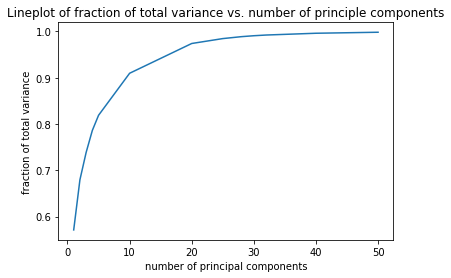

In [64]:
def get_pca_components(data):
  k = [1, 2, 3, 4, 5, 10, 20, 25, 28, 30, 32, 40, 50]
  explained_variances = []
  print('Components \t Fraction of explained variance')
  for components in k:
    pca = PCA(n_components = components)
    data_pc = pca.fit_transform(data)
    fraction_of_variance = sum(pca.explained_variance_ratio_)
    print('\t',components,'\t',fraction_of_variance)
    explained_variances.append(fraction_of_variance)
  print('\n')
  plt.plot(k, explained_variances)
  plt.xlabel("number of principal components")
  plt.ylabel("fraction of total variance")
  plt.title("Lineplot of fraction of total variance vs. number of principle components")
  plt.show()
  pass

get_pca_components(data = features)

In [65]:
components = 30
pca = PCA(n_components = components)
data_pca = pca.fit_transform(features)
# dump(pca, main_dir + 'Models/Males_B/PCA/Males_B_pca.joblib') 
print( data_pca[2])
print(data_pca.shape)

[  8.09406537  18.3422633  -22.89449813 -31.89384753   1.6212101
   8.19613111  12.0265814   14.83649834 -10.17286577   0.41659857
  -6.83943229  -4.11098781  -4.93703396  -3.26561532   0.57427882
  -1.48356587   0.15687465   0.89597961   0.15714956   3.14680307
  -5.61544361  -2.2741094    8.90081625   7.11846061  -4.99785363
   0.85969024  -0.6615256   -1.57287323   2.28833926  -1.49276742]
(1299, 30)


In [66]:
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(data_pca)
# dump(standard_scaler, main_dir + 'Models/Males_B/Scaler/Males_B_scaler.joblib')
X = np.array(X)
y = np.array(targets)


le = LabelEncoder()
y_categorical = to_categorical(le.fit_transform(y))
 
x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.135)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size = 0.145)

print('x_train: ',len(x_train))
print('y_train: ', len(y_train))
print('x_test: ',len(x_test))
print('y_test: ',len(y_test))
print('x_dev: ',len(x_dev))
print('y_dev: ',len(y_dev))

x_train:  960
y_train:  960
x_test:  176
y_test:  176
x_dev:  163
y_dev:  163


In [25]:

# def train_test_split_dataset(features, targets, test_size, validation_size):
#   X = np.array(features)
#   y = np.array(targets)

#   X = StandardScaler().fit_transform(X)
#   # X = MinMaxScaler().fit_transform(X)

#   # Encode the classification labels
#   le = LabelEncoder()
#   y_categorical = to_categorical(le.fit_transform(y))
  
#   train_X, test_X, train_y, test_y = train_test_split(X, y_categorical, test_size=test_size)
#   train_X, validation_X, train_y, validation_y = train_test_split(train_X, train_y, test_size = validation_size)

#   print('x_train: ',len(train_X))
#   print('y_train: ', len(train_y))
#   print('x_test: ',len(test_X))
#   print('y_test: ',len(test_y))
#   print('x_dev: ',len(validation_X))
#   print('y_dev: ',len(validation_y))

#   split_dataset = ((train_X, train_y), (validation_X, validation_y), (test_X, test_y))

#   return split_dataset


# #split the dataset into training, testing and validation sets
# split_dataset = train_test_split_dataset(features, targets, test_size=0.1, validation_size=0.1)



x_train:  1422
y_train:  1422
x_test:  176
y_test:  176
x_dev:  159
y_dev:  159


#KNN Model

In [74]:
def knn_model_builder(x_train, y_train, x_test, y_test):
  for i in range(2, 10):
    print(i)
    knn_cv = KNeighborsClassifier(n_neighbors=i)
    # knn.fit(x_train, y_train)
    # # knn.predict(X)
    # print(knn.score(x_test,y_test))
    cv_scores = cross_val_score(knn_cv, x_train, y_train, cv=5)
    #print each cv score (accuracy) and average them
    print(cv_scores)
    print('cv_scores mean:{}'.format(np.mean(cv_scores)))
  pass


knn_model_builder(x_train, y_train, x_dev, y_dev)


2
[0.53645833 0.58854167 0.59375    0.58333333 0.609375  ]
cv_scores mean:0.5822916666666667
3
[0.703125   0.72916667 0.77604167 0.70833333 0.80208333]
cv_scores mean:0.74375
4
[0.55208333 0.57291667 0.640625   0.59895833 0.65625   ]
cv_scores mean:0.6041666666666667
5
[0.66666667 0.734375   0.75       0.69791667 0.77083333]
cv_scores mean:0.7239583333333333
6
[0.578125   0.59375    0.625      0.58854167 0.61979167]
cv_scores mean:0.6010416666666666
7
[0.671875   0.6875     0.76041667 0.67708333 0.70833333]
cv_scores mean:0.7010416666666667
8
[0.56770833 0.609375   0.63541667 0.59895833 0.625     ]
cv_scores mean:0.6072916666666667
9
[0.63541667 0.69791667 0.71875    0.65104167 0.69270833]
cv_scores mean:0.6791666666666666


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 3

# import some data to play with
X = x_train  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = y_train

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#AAFAAF', '#FAAAAF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#00F00F', '#F0000F' ])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(X)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

ValueError: ignored

In [68]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [69]:
knn_gscv.best_score_

0.78125

In [70]:
knn_gscv.best_params_

{'n_neighbors': 1}

In [73]:
from sklearn.model_selection import cross_val_score

#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)

#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, x_train, y_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.703125   0.72916667 0.77604167 0.70833333 0.80208333]
cv_scores mean:0.74375
